Numerically, it is a bit more straightforward to estimate the total variation of a random process (trace of its covariance matrix) from a set of samples than its total entropy.

As before, we consider the random process with samples given by

$$r(\tau) = [1 - e^{-1/\tau}]\sum_{m=0}^\infty e^{-m/\tau} s_m$$

where $\{s_m\}$ are binary values sampled from some random process of their own. Or defining $a = \exp(-1/\tau), \tau = -1/\log a$ we can write

$$r(-1/\log a) = [1-a]\sum_{m=0}^\infty a^m s_m$$

where $a = 0 \rightarrow \tau = 0$, $a = 1 \rightarrow \tau = \infty$.

Given some $P(\{s_m\})$ we can now sample $r(-1/\log a)$ over the domain $a \in [0, 1)$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_font_size

NA = 100
A = np.linspace(0, 1, NA+1)[:-1]

print(f'a_min = {A[0]}, a_max = {A[-1]}, da = {np.mean(np.diff(A))}')
print(f'tau_min = {-1/np.log(A[0])}, tau_max = {-1/np.log(A[-1])}')

NTR = 100000
M_MAX = int(round(-10/np.log(A[-1])))

print(f'# samples = {NTR}, m_max = {M_MAX}')

def sample_mkv(q, n_t):
    """Sample from balanced markov chain with switching probability q."""
    s_m = [np.random.binomial(1, .5)]
    for ct in range(1, n_t):
        s_m.append(s_m[ct-1] if np.random.rand() < (1-q) else 1-s_m[ct-1])
        
    return np.array(s_m).astype(bool)

a_min = 0.0, a_max = 0.99, da = 0.01
tau_min = 0.0, tau_max = 99.49916247342207
# samples = 100000, m_max = 995


Let $a_m = [1-a]a^m$ so that

$$r(-1/\log a) = \sum_{m=0}^\infty a_ms_m$$

In [2]:
a_m = (1-A) * (np.tile(A[None, :], (M_MAX, 1))**np.tile(np.arange(M_MAX)[:, None], (1, NA)))

In [3]:
# take samples
try:
    data = np.load('binary_samples.npy', allow_pickle=True)[0]
    s_ms = data['s_ms']
    rs_a = data['rs_a']
    
except:
    s_ms = {}
    rs_a = {}
    
    # i.i.d. bernoulli
    for q in [0.5, 0.25, 0.1]:
        key = f'i.i.d. bernoulli q={q}'
        print(key, '...')
        
        s_m = []
        for ctr in range(NTR):
            s_m.append(np.random.binomial(1, q, M_MAX))

        s_m = np.array(s_m).astype(bool)

        s_ms[key] = s_m
        rs_a[key] = s_m @ a_m

    # symmetric markov chain w/ detailed balance
    for q in [.001, .01, .1, .25, .4, .5, .6, .75, .9, .99, .999]:
        key = f'balanced markov q={q}'
        print(key, '...')
        s_m = []
        for ctr in range(NTR):
            s_m.append(sample_mkv(q, M_MAX))

        s_m = np.array(s_m).astype(bool)
        
        s_ms[key] = s_m
        rs_a[key] = s_m @ a_m

i.i.d. bernoulli q=0.5 ...
i.i.d. bernoulli q=0.25 ...
i.i.d. bernoulli q=0.1 ...
balanced markov q=0.001 ...
balanced markov q=0.01 ...
balanced markov q=0.1 ...
balanced markov q=0.25 ...
balanced markov q=0.4 ...
balanced markov q=0.5 ...
balanced markov q=0.6 ...
balanced markov q=0.75 ...
balanced markov q=0.9 ...
balanced markov q=0.99 ...
balanced markov q=0.999 ...


In [4]:
np.save('binary_samples.npy', np.array([{'s_ms': s_ms, 'a': A, 'rs_a': rs_a}]))

In [5]:
# compute covariance matrices
covs = {}
cov_traces = {}
for key, r_a in rs_a.items():
    covs[key] = np.cov(r_a.T)
    cov_traces[key] = np.trace(covs[key])/NA

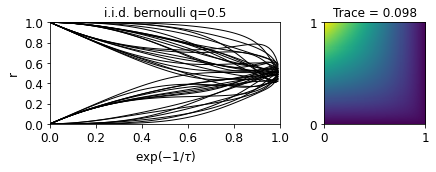

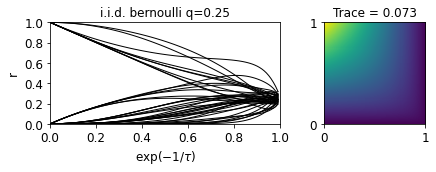

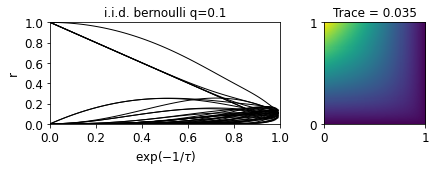

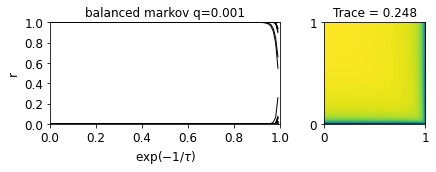

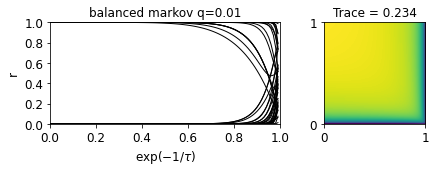

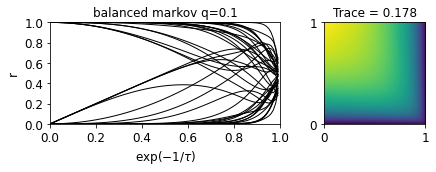

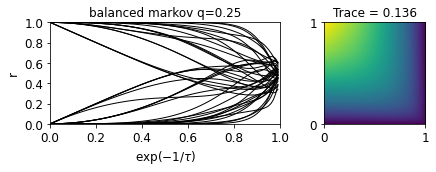

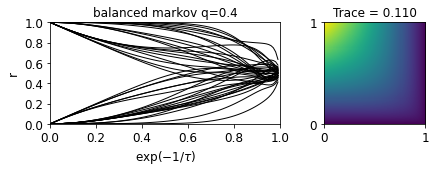

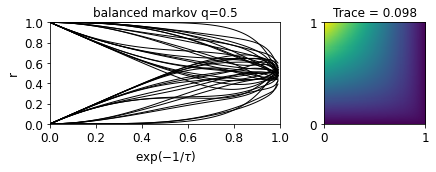

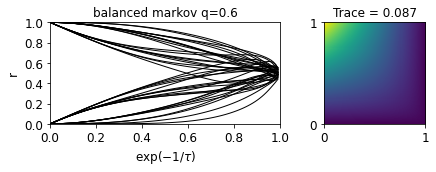

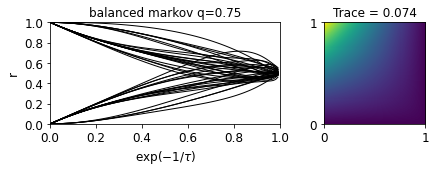

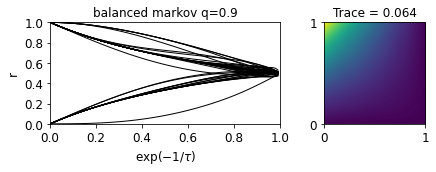

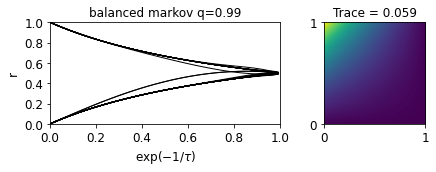

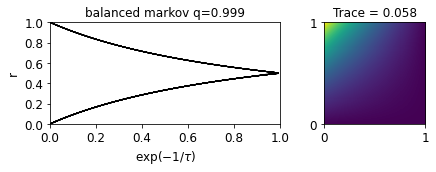

In [6]:
NR_PLOT = 40

for key, r_a in rs_a.items():
    fig, axs = plt.subplots(1, 2, figsize=(7, 2.5), tight_layout=True)
    axs[0].plot(A, r_a[:NR_PLOT].T, c='k', lw=1)
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel(r'$\exp(-1/\tau)$')
    axs[0].set_ylabel('r')
    axs[0].set_title(key)
    
    axs[1].matshow(covs[key], extent=[0, 1, 0, 1])
    axs[1].xaxis.tick_bottom()
    axs[1].set_title(f'Trace = {cov_traces[key]:.3f}')
    
    set_font_size(axs, 12)

# Estimate entropies

In [16]:
A_H = [.5, .8, .9, .95, .99]
IA_H = [(A < a_h).sum() for a_h in A_H]
NBIN = 27

for key, r_a in rs_a.items():
    print('\n', key, '...')
    
    hs = []
    nbins_total = []
    
    for na_h in np.arange(len(A_H))+1:
        sys.stdout.write('{a_h} = ' + f'{A_H[:na_h]}, ')
        ia_h = IA_H[:na_h]
        cts = np.histogramdd(r_a[:, ia_h], bins=[np.linspace(0, 1, NBIN+1)]*na_h)[0]
        
        h = stats.entropy(cts.flatten()/cts.sum(), base=2)
        hs.append(h)
        nbins_total.append(cts.size)
    
    print(hs)


 i.i.d. bernoulli q=0.5 ...
{a_h} = [0.5], {a_h} = [0.5, 0.8], {a_h} = [0.5, 0.8, 0.9], {a_h} = [0.5, 0.8, 0.9, 0.95], {a_h} = [0.5, 0.8, 0.9, 0.95, 0.99], [4.7547680523886555, 7.322115667011989, 9.016443539034043, 10.36148873070946, 11.70746809186472]

 i.i.d. bernoulli q=0.25 ...
{a_h} = [0.5], {a_h} = [0.5, 0.8], {a_h} = [0.5, 0.8, 0.9], {a_h} = [0.5, 0.8, 0.9, 0.95], {a_h} = [0.5, 0.8, 0.9, 0.95, 0.99], [3.870083340186972, 6.159258712319767, 7.713681848462785, 8.970332269510878, 10.19813911310233]

 i.i.d. bernoulli q=0.1 ...
{a_h} = [0.5], {a_h} = [0.5, 0.8], {a_h} = [0.5, 0.8, 0.9], {a_h} = [0.5, 0.8, 0.9, 0.95], {a_h} = [0.5, 0.8, 0.9, 0.95, 0.99], [2.116719364252183, 3.721665234380237, 4.971844129074519, 6.037304861402093, 6.983181995732667]

 balanced markov q=0.001 ...
{a_h} = [0.5], {a_h} = [0.5, 0.8], {a_h} = [0.5, 0.8, 0.9], {a_h} = [0.5, 0.8, 0.9, 0.95], {a_h} = [0.5, 0.8, 0.9, 0.95, 0.99], [1.0473401909521018, 1.157177146961038, 1.3191814463344065, 1.680894196677695, 3.

# Plot example distributions for large $\tau$ and different seq statistics

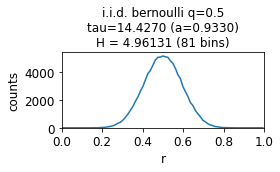

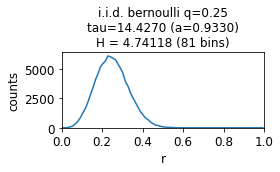

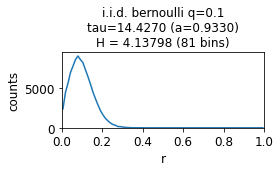

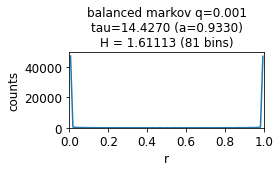

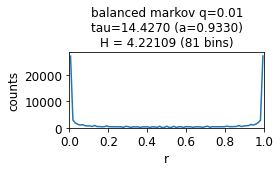

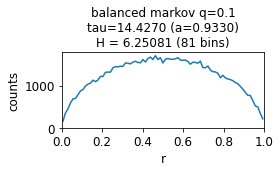

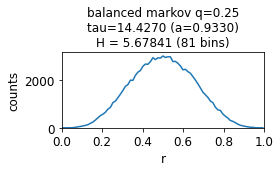

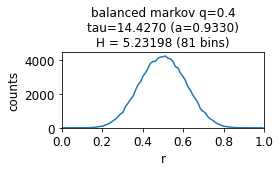

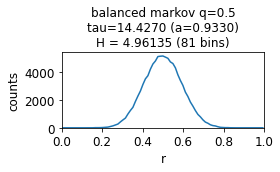

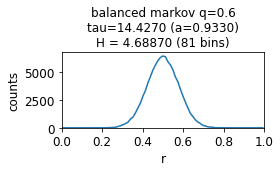

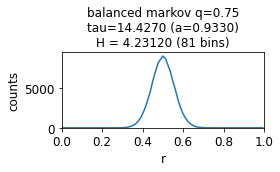

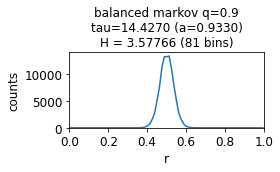

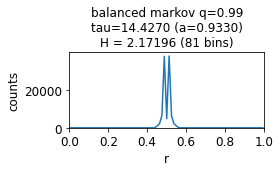

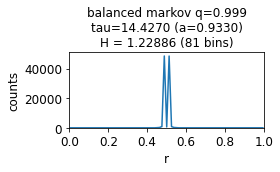

In [11]:
tau_xpl = 10/np.log(2)
bins = np.linspace(0, 1, 81+1)
binc = .5*(bins[:-1] + bins[1:])

for key, s_m in s_ms.items():
    rm = np.arange(M_MAX)
    r_tau = (1 - np.exp(-1/tau_xpl)) * (s_m @ np.exp(-rm/tau_xpl))
    
    cts = np.histogram(r_tau, bins=bins)[0]
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), tight_layout=True)
    ax.plot(binc, cts)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('r')
    ax.set_ylabel('counts')
    ax.set_title(f'{key}\ntau={tau_xpl:.4f} (a={np.exp(-1/tau_xpl):.4f})\nH = {stats.entropy(cts/cts.sum(), base=2):.5f} ({len(bins)-1} bins)')
    
    set_font_size(ax, 12)